In [19]:
import numpy as np
import pandas as pd
import warnings
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
warnings.filterwarnings("ignore")

file_path = "C:/Users/user/OneDrive/Documentssp500_data.xlsx"

df = pd.read_excel(file_path, parse_dates =["Date"])
df =df.set_index("Date").sort_index()

print(df.head())




                  Close         High          Low         Open       Volume
Date                                                                       
2005-01-01  1181.270020  1217.800049  1163.750000  1211.920044  31498800000
2005-02-01  1203.599976  1212.439941  1180.949951  1181.270020  29297410000
2005-03-01  1180.589966  1229.109985  1163.689941  1203.599976  39014150000
2005-04-01  1156.849976  1191.880005  1136.150024  1180.589966  43424270000
2005-05-01  1191.500000  1199.560059  1146.180054  1156.849976  39321990000


In [10]:
# --- Safety: ensure datetime index & sort & filter ---
df = df.copy()
df.index = pd.to_datetime(df.index, errors="coerce")
df = df[df.index.notna()].sort_index()
df = df[df.index >= "2005-01-01"]

for col in ["High", "Low"]:
    if col not in df.columns:
        raise ValueError(f"Missing column '{col}'. Available: {list(df.columns)}")

print("Date range:", df.index.min().date(), "→", df.index.max().date(), "| rows:", len(df))

Date range: 2005-01-31 → 2025-06-30 | rows: 246


In [11]:
# --- Train/Test split (fixed at 2015-01-01) ---
SPLIT = pd.Timestamp("2015-01-01")
train_idx = df.index < SPLIT
test_idx  = df.index >= SPLIT

In [12]:
 
# choose series
yH_train, yH_test = df.loc[train_idx, "High"].dropna(), df.loc[test_idx, "High"].dropna()
yL_train, yL_test = df.loc[train_idx, "Low"].dropna(),  df.loc[test_idx, "Low"].dropna()

print(f"High  train: {yH_train.index.min().date()} → {yH_train.index.max().date()} (n={len(yH_train)})")
print(f"High   test: {yH_test.index.min().date() if len(yH_test) else '—'} → "
      f"{yH_test.index.max().date() if len(yH_test) else '—'} (n={len(yH_test)})")
print(f"Low   train: {yL_train.index.min().date()} → {yL_train.index.max().date()} (n={len(yL_train)})")
print(f"Low    test: {yL_test.index.min().date() if len(yL_test) else '—'} → "
      f"{yL_test.index.max().date() if len(yL_test) else '—'} (n={len(yL_test)})")

if len(yH_train) < 24 or len(yL_train) < 24:
    print("[Warning] Very small training window; results may be unstable.")

High  train: 2005-01-31 → 2014-12-31 (n=120)
High   test: 2015-01-31 → 2025-06-30 (n=126)
Low   train: 2005-01-31 → 2014-12-31 (n=120)
Low    test: 2015-01-31 → 2025-06-30 (n=126)


In [20]:
def select_model(y_train):
    """Return (fitted_result, order, seasonal_order, used_log)."""
    y = y_train.copy()
   
    best = (np.inf, None, None, None, None)

    for use_log in ([True, False] if USE_LOG else [False]):
        yt = np.log(y) if use_log else y
        for order in grid_orders:
            for seas in grid_seasonals:
                try:
                    mod = SARIMAX(
                        yt, order=order, seasonal_order=seas, trend="c",
                        enforce_stationarity=False, enforce_invertibility=False
                    )
                    res = mod.fit(disp=False)
                    if np.isfinite(res.aic) and res.aic < best[0]:
                        best = (res.aic, res, order, seas, use_log)
                except Exception:
                    continue

    aic, res, order, seas, use_log = best
    if res is None:
        raise RuntimeError("No SARIMA spec converged; broaden grid or inspect data.")

    print(f"Selected SARIMA {order} x {seas} (log={use_log})  AIC={aic:.1f}")
    return res, order, seas, use_log

# === Call it ===
resH, ordH, seasH, logH = select_model(yH_train)
print(f"[High]  order={ordH}, seasonal={seasH}, log={logH}")

resL, ordL, seasL, logL = select_model(yL_train)
print(f"[Low ]  order={ordL}, seasonal={seasL}, log={logL}")


Selected SARIMA (1, 1, 0) x (0, 0, 0, 12) (log=True)  AIC=-478.4
[High]  order=(1, 1, 0), seasonal=(0, 0, 0, 12), log=True
Selected SARIMA (0, 1, 0) x (0, 0, 0, 12) (log=True)  AIC=-345.4
[Low ]  order=(0, 1, 0), seasonal=(0, 0, 0, 12), log=True


In [13]:
# ======================================================
# 1) Model selection with a BIGGER grid + optional log
# ======================================================
USE_LOG = True            # set False to disable
SEASONAL_PERIOD = 12

# Expanded grid (kept reasonable for speed):
p = q = range(0, 3)       # 0,1,2
d = [1, 2]                # allow proper differencing
P = Q = range(0, 2)       # 0,1
D = [0, 1]                # seasonal differencing
grid_orders = list(itertools.product(p, d, q))
grid_seasonals = [(i, j, k, SEASONAL_PERIOD) for i, j, k in itertools.product(P, D, Q)]

def select_model(y_train):
    """Return (fitted_result, order, seasonal_order, used_log)."""
    y = y_train.copy()
    best = (np.inf, None, None, None)  # (AIC, res, order, seasonal)
    
    for use_log in ([True, False] if USE_LOG else [False]):
        yt = np.log(y) if use_log else y
        for order in grid_orders:
            for seas in grid_seasonals:
                try:
                    mod = SARIMAX(
                        yt, order=order, seasonal_order=seas, trend="c",
                        enforce_stationarity=False, enforce_invertibility=False
                    )
                    res = mod.fit(disp=False)
                    if np.isfinite(res.aic) and res.aic < best[0]:
                        best = (res.aic, res, order, seas, use_log)
                except Exception:
                    continue
    if best[1] is None:
        raise RuntimeError("No SARIMA spec converged; broaden grid or inspect data.")
    aic, res, order, seas, use_log = best
    print(f"Selected SARIMA {order} x {seas}  (log={use_log})  AIC={aic:.1f}")
    return res, order, seas, use_log
# === Add this right after the function definitions ===
resH, ordH, seasH, logH = select_model(yH_train)
print(f"[High]  order={ordH}, seasonal={seasH}, log={logH}")

resL, ordL, seasL, logL = select_model(yL_train)
print(f"[Low ]  order={ordL}, seasonal={seasL}, log={logL}")



# ======================================================
# 2) Rolling one-step-ahead forecasts (refit each month)
# ======================================================
def rolling_forecast(y_train, y_test, order, seas, use_log):
    """Refit on expanding window and forecast 1-step ahead each month."""
    preds = []
    idx = []
    history = y_train.copy()
    for t in y_test.index:
        yt = np.log(history) if use_log else history
        res = SARIMAX(
            yt, order=order, seasonal_order=seas, trend="c",
            enforce_stationarity=False, enforce_invertibility=False
        ).fit(disp=False)
        f = res.get_forecast(steps=1).predicted_mean.iloc[0]
        pred = np.exp(f) if use_log else f
        preds.append(pred)
        idx.append(t)
        # append true observation to history for next step
        history.loc[t] = y_test.loc[t]
    return pd.Series(preds, index=pd.Index(idx, name=y_test.index.name))
 

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Selected SARIMA (1, 1, 0) x (0, 0, 0, 12)  (log=True)  AIC=-478.4
[High]  order=(1, 1, 0), seasonal=(0, 0, 0, 12), log=True


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Selected SARIMA (0, 1, 0) x (0, 0, 0, 12)  (log=True)  AIC=-345.4
[Low ]  order=(0, 1, 0), seasonal=(0, 0, 0, 12), log=True


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:

yH_pred_test = rolling_forecast(yH_train, yH_test, ordH, seasH, logH)
yL_pred_test = rolling_forecast(yL_train, yL_test, ordL, seasL, logL)


In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def metrics_with_pointwise_mape(actual, pred):
    # Aggregate metrics
    mae = mean_absolute_error(actual, pred)
    rmse = mean_squared_error(actual, pred) ** 0.5
    mape = (np.abs((actual - pred) / actual).mean()) * 100  # overall MAPE
    
    # Per-point errors, including individual MAPE values
    errors = pd.DataFrame({
        'Actual': actual,
        'Predicted': pred,
        'Error': pred - actual,  # signed error
        'Absolute Error': np.abs(pred - actual),
        'Pointwise MAPE (%)': (np.abs((actual - pred) / actual)) * 100
    }, index=actual.index)  # keep original date index if available

    return mae, rmse, mape, errors


In [27]:
if len(yH_test) > 0:
    maeH, rmseH, mapeH, errorsH = metrics_with_pointwise_mape(yH_test, yH_pred_test)
    print(f"[High]  MAE: {maeH:,.1f}  RMSE: {rmseH:,.1f}  MAPE (avg): {mapeH:,.2f}%")
    print(errorsH)  # shows per-point MAPE for each observation

if len(yL_test) > 0:
    maeL, rmseL, mapeL, errorsL = metrics_with_pointwise_mape(yL_test, yL_pred_test)
    print(f"[Low ]  MAE: {maeL:,.1f}  RMSE: {rmseL:,.1f}  MAPE (avg): {mapeL:,.2f}%")
    print(errorsL)


[High]  MAE: 73.1  RMSE: 102.1  MAPE (avg): 2.00%
                 Actual    Predicted       Error  Absolute Error  \
Date                                                               
2015-01-31  2072.360107  2106.377366   34.017259       34.017259   
2015-02-28  2119.590088  2070.465504  -49.124584       49.124584   
2015-03-31  2117.520020  2143.613865   26.093845       26.093845   
2015-04-30  2125.919922  2123.005041   -2.914881        2.914881   
2015-05-31  2134.719971  2135.281248    0.561278        0.561278   
...                 ...          ...         ...             ...   
2025-02-28  6147.430176  6165.819638   18.389463       18.389463   
2025-03-31  5986.089844  6182.292575  196.202731      196.202731   
2025-04-30  5695.310059  5964.185754  268.875695      268.875695   
2025-05-31  5968.609863  5630.641546 -337.968318      337.968318   
2025-06-30  6215.080078  6081.653748 -133.426330      133.426330   

            Pointwise MAPE (%)  
Date                            

In [28]:
# Force pandas to show all rows
pd.set_option('display.max_rows', None)

print(errorsL)  # will now display the entire DataFrame


                 Actual    Predicted       Error  Absolute Error  \
Date                                                               
2015-01-31  1988.119995  1981.144670   -6.975325        6.975325   
2015-02-28  1980.900024  1996.831215   15.931191       15.931191   
2015-03-31  2039.689941  1989.446722  -50.243220       50.243220   
2015-04-30  2048.379883  2048.912497    0.532614        0.532614   
2015-05-31  2067.929932  2057.637261  -10.292671       10.292671   
2015-06-30  2056.320068  2077.359849   21.039781       21.039781   
2015-07-31  2044.020020  2065.527384   21.507364       21.507364   
2015-08-31  1867.010010  2053.000259  185.990249      185.990249   
2015-09-30  1871.910034  1873.799711    1.889677        1.889677   
2015-10-31  1893.699951  1878.702555  -14.997396       14.997396   
2015-11-30  2019.390015  1900.689530 -118.700485      118.700485   
2015-12-31  1993.260010  2027.795468   34.535458       34.535458   
2016-01-31  1812.290039  2001.292162  189.002123

In [32]:
# ======================================================
# 4) Metrics on the test window
# ======================================================
def metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    rmse = mean_squared_error(actual, pred) ** 0.5  # manual square root
    mape = (np.abs((actual - pred) / actual).mean()) * 100
    return mae, rmse, mape

if len(yH_test) > 0:
    maeH, rmseH, mapeH = metrics(yH_test, yH_pred_test)
    print(f"[High]  MAE: {maeH:,.1f}  RMSE: {rmseH:,.1f}  MAPE: {mapeH:,.2f}%")
if len(yL_test) > 0:
    maeL, rmseL, mapeL = metrics(yL_test, yL_pred_test)
    print(f"[Low ]  MAE: {maeL:,.1f}  RMSE: {rmseL:,.1f}  MAPE: {mapeL:,.2f}%")

 

[High]  MAE: 73.1  RMSE: 102.1  MAPE: 2.00%
[Low ]  MAE: 122.1  RMSE: 179.9  MAPE: 3.63%


In [33]:
# ======================================================
# 5) 12-month ahead forecast from the full sample
# ======================================================
def future_forecast(full_series, order, seas, use_log, steps=12):
    y = np.log(full_series) if use_log else full_series
    res = SARIMAX(
        y, order=order, seasonal_order=seas, trend="c",
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)
    f = res.get_forecast(steps=steps)
    mean = f.predicted_mean
    ci = f.conf_int()
    if use_log:
        mean = np.exp(mean)
        ci = np.exp(ci)
    # Nice month-end index
    fut_idx = pd.period_range(full_series.index[-1], periods=steps+1, freq='M')[1:].to_timestamp('M')
    mean.index = fut_idx; ci.index = fut_idx
    return mean, ci

H_future_mean, H_future_ci = future_forecast(df["High"], ordH, seasH, logH, steps=12)
L_future_mean, L_future_ci = future_forecast(df["Low"],  ordL, seasL, logL, steps=12)

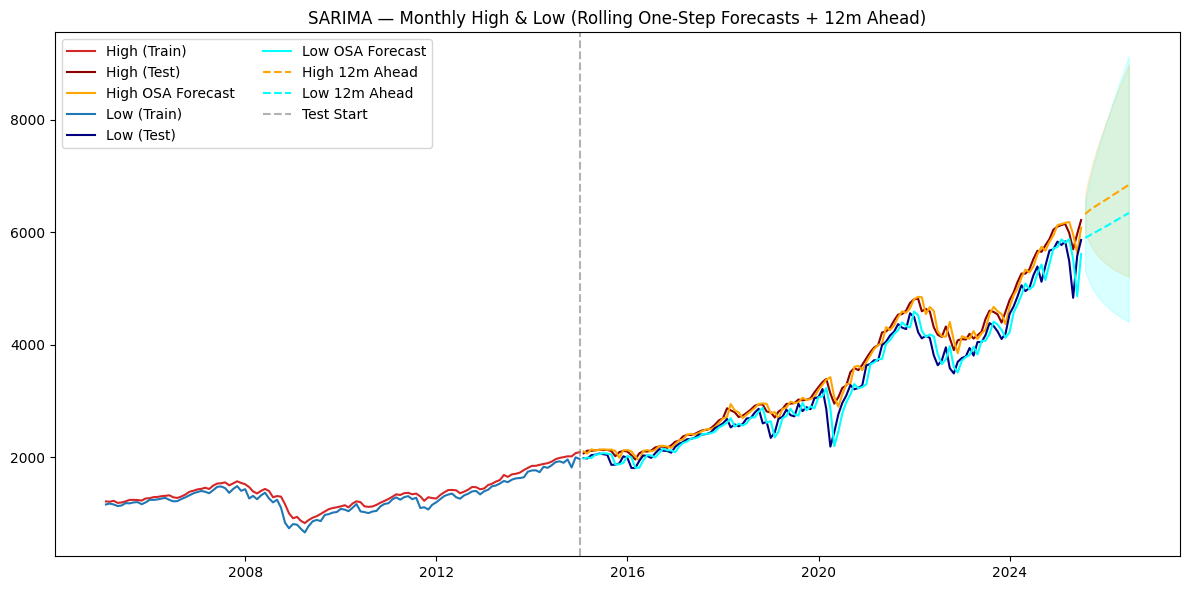

In [30]:
# ======================================================
# 6) Plot — rolling test forecast (tracks better) + 12m ahead
# ======================================================
plt.figure(figsize=(12, 6))

# High actuals
plt.plot(yH_train.index, yH_train, label='High (Train)', color='tab:red')
plt.plot(yH_test.index,  yH_test,  label='High (Test)', color='darkred')
# High rolling forecast on test
plt.plot(yH_pred_test.index, yH_pred_test, label='High OSA Forecast', color='orange')

# Low actuals
plt.plot(yL_train.index, yL_train, label='Low (Train)', color='tab:blue')
plt.plot(yL_test.index,  yL_test,  label='Low (Test)', color='navy')
# Low rolling forecast on test
plt.plot(yL_pred_test.index, yL_pred_test, label='Low OSA Forecast', color='cyan')

# 12-month ahead (transparent fill)
plt.plot(H_future_mean.index, H_future_mean, label='High 12m Ahead', color='orange', linestyle='--')
plt.fill_between(H_future_mean.index, H_future_ci.iloc[:, 0], H_future_ci.iloc[:, 1], color='orange', alpha=0.15)
plt.plot(L_future_mean.index, L_future_mean, label='Low 12m Ahead', color='cyan', linestyle='--')
plt.fill_between(L_future_mean.index, L_future_ci.iloc[:, 0], L_future_ci.iloc[:, 1], color='cyan', alpha=0.15)

plt.axvline(SPLIT, linestyle='--', color='gray', alpha=0.6, label='Test Start')
plt.title('SARIMA — Monthly High & Low (Rolling One-Step Forecasts + 12m Ahead)')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [34]:
# Combine actual & forecast for Highs
df_high_compare = pd.DataFrame({
    "Actual_High": yH_test,
    "Forecast_High": yH_pred_test
})

# Combine actual & forecast for Lows
df_low_compare = pd.DataFrame({
    "Actual_Low": yL_test,
    "Forecast_Low": yL_pred_test
})

# Display side-by-side (limit to first 12 rows for readability)
print("\n=== Highs: Actual vs Forecast (Test Period) ===")
print(df_high_compare.head(12).to_string())

print("\n=== Lows: Actual vs Forecast (Test Period) ===")
print(df_low_compare.to_string())



=== Highs: Actual vs Forecast (Test Period) ===
            Actual_High  Forecast_High
Date                                  
2015-01-31  2072.360107    2106.377366
2015-02-28  2119.590088    2070.465504
2015-03-31  2117.520020    2143.613865
2015-04-30  2125.919922    2123.005041
2015-05-31  2134.719971    2135.281248
2015-06-30  2129.870117    2144.249479
2015-07-31  2132.820068    2134.283787
2015-08-31  2112.659912    2140.073738
2015-09-30  2020.859985    2111.246210
2015-10-31  2094.320068    1992.861564
2015-11-30  2116.479980    2126.840324
2015-12-31  2104.270020    2130.345079

=== Lows: Actual vs Forecast (Test Period) ===
             Actual_Low  Forecast_Low
Date                                 
2015-01-31  1988.119995   1981.144670
2015-02-28  1980.900024   1996.831215
2015-03-31  2039.689941   1989.446722
2015-04-30  2048.379883   2048.912497
2015-05-31  2067.929932   2057.637261
2015-06-30  2056.320068   2077.359849
2015-07-31  2044.020020   2065.527384
2015-08-31  186

In [35]:
import yfinance as yf

# =========================================
# 0) Monthly forecasts you already have
#    yH_pred_test: pd.Series (Forecast High), index = monthly dates
#    yL_pred_test: pd.Series (Forecast Low),  index = monthly dates
# =========================================
monthly_fcst = pd.DataFrame({
    "Forecast_High": yH_pred_test,
    "Forecast_Low":  yL_pred_test
}).dropna()

# Normalize to month-end index with explicit freq
monthly_fcst.index = pd.to_datetime(monthly_fcst.index, errors="coerce")
monthly_fcst = monthly_fcst[monthly_fcst.index.notna()].sort_index()
monthly_fcst.index = monthly_fcst.index.to_period("M").to_timestamp("M")
monthly_fcst.index.name = "MonthEnd"
try:
    monthly_fcst = monthly_fcst.asfreq("ME")  # pandas 2.2+ month-end alias
except Exception:
    monthly_fcst = monthly_fcst.asfreq("M")   # fallback for older pandas

In [36]:


# =========================================
# 1) Pull daily S&P 500 Close and merge by MonthEnd
# =========================================
start_daily = (monthly_fcst.index.min() - pd.offsets.MonthBegin(1)).date()
end_daily   = (monthly_fcst.index.max() + pd.offsets.MonthEnd(1)).date()

daily = yf.download("^GSPC", start=str(start_daily), end=str(end_daily), progress=False)

# Flatten MultiIndex columns if present (yfinance sometimes returns them)
if isinstance(daily.columns, pd.MultiIndex):
    daily.columns = daily.columns.get_level_values(0)

daily = daily[["Close"]].copy()
daily.index = pd.to_datetime(daily.index)
daily = daily.sort_index()
daily["MonthEnd"] = daily.index.to_period("M").to_timestamp("M")

# Robust merge (both sides have 'MonthEnd')
left  = daily.reset_index()                    # columns: ['Date','Close','MonthEnd']
right = monthly_fcst.reset_index()             # columns: ['MonthEnd','Forecast_High','Forecast_Low']

daily_merged = (
    left.merge(right, on="MonthEnd", how="left")
        .set_index("Date")
        .sort_index()
)

# Keep only months where forecasts exist
daily_merged = daily_merged[
    daily_merged["Forecast_High"].notna() & daily_merged["Forecast_Low"].notna()
].copy()


In [37]:


# =========================================
# 2) 75% near-low execution rule (hold shares; no selling)
#    - 75% of monthly_budget on first day closer to Low than High
#    - remaining 25% at month-end
#    - if no trigger day -> 100% at month-end
# =========================================
monthly_budget = 1000.0
shares = 0.0
records = []

for m, dfm in daily_merged.groupby("MonthEnd"):
    f_high = float(dfm["Forecast_High"].iloc[0])
    f_low  = float(dfm["Forecast_Low"].iloc[0])

    # Find first trading day where price is closer to Low than High
    dist_low  = (dfm["Close"] - f_low).abs()
    dist_high = (dfm["Close"] - f_high).abs()
    closer_to_low = dist_low < dist_high
    trigger_date = closer_to_low.idxmax() if closer_to_low.any() else None
    if trigger_date is not None and not closer_to_low.loc[trigger_date]:
        trigger_date = None  # safety

    # Month-end price for late tranche & valuation
    end_date = dfm.index.max()
    end_price = float(dfm.loc[end_date, "Close"])

    start_buy_date = None
    start_buy_price = np.nan
    shares_early = 0.0
    shares_late  = 0.0

    if trigger_date is not None:
        start_buy_date = trigger_date
        start_buy_price = float(dfm.loc[start_buy_date, "Close"])
        budget_early = 0.75 * monthly_budget
        shares_early = budget_early / start_buy_price

        budget_late = 0.25 * monthly_budget
        shares_late = budget_late / end_price
    else:
        budget_late = monthly_budget
        shares_late = budget_late / end_price

    # Update holdings and equity at month-end
    shares += (shares_early + shares_late)
    equity = shares * end_price

    records.append({
        "MonthEnd": m,
        "Forecast_Low": round(f_low, 2),
        "Forecast_High": round(f_high, 2),
        "Trigger_Date": start_buy_date.strftime("%Y-%m-%d") if start_buy_date else "",
        "Trigger_Price": round(start_buy_price, 2) if start_buy_date else np.nan,
        "End_Price": round(end_price, 2),
        "Shares_Bought_75": round(shares_early, 6),
        "Shares_Bought_25_or_100": round(shares_late, 6),
        "Total_Shares": round(shares, 6),
        "Equity_at_MonthEnd": round(equity, 2),
    })

strategy = pd.DataFrame(records).set_index("MonthEnd").sort_index()

# =========================================
# 3) Output
# =========================================
pd.set_option("display.max_rows", None)
print("\n=== 75% Near-Low Strategy (Daily exec, Monthly forecasts) ===")
print(strategy)
pd.reset_option("display.max_rows")

total_contrib = monthly_budget * len(strategy)
final_equity = strategy["Equity_at_MonthEnd"].iloc[-1]
total_return = final_equity / total_contrib - 1
cagr = (final_equity / total_contrib) ** (12 / len(strategy)) - 1  # rough for constant contributions

print(f"\nMonths: {len(strategy)}")
print(f"Total contributed: {total_contrib:,.2f}")
print(f"Final equity:      {final_equity:,.2f}")
print(f"Total return vs contributions: {total_return*100:.2f}%")
print(f"CAGR (approx): {cagr*100:.2f}%")



=== 75% Near-Low Strategy (Daily exec, Monthly forecasts) ===
            Forecast_Low  Forecast_High Trigger_Date  Trigger_Price  \
MonthEnd                                                              
2015-01-31       1981.14        2106.38   2015-01-05        2020.58   
2015-02-28       1996.83        2070.47   2015-02-02        2020.85   
2015-03-31       1989.45        2143.61   2015-03-10        2044.16   
2015-04-30       2048.91        2123.01   2015-04-01        2059.69   
2015-05-31       2057.64        2135.28   2015-05-05        2089.46   
2015-06-30       2077.36        2144.25   2015-06-02        2109.60   
2015-07-31       2065.53        2134.28   2015-07-01        2077.42   
2015-08-31       2053.00        2140.07   2015-08-04        2093.32   
2015-09-30       1873.80        2111.25   2015-09-01        1913.85   
2015-10-31       1878.70        1992.86   2015-10-01        1923.82   
2015-11-30       1900.69        2126.84                         NaN   
2015-12-31    

In [38]:
# =========================================
# Baseline DCA: invest 100% at month-end
# =========================================
shares_b = 0.0
records_b = []

for m, dfm in daily_merged.groupby("MonthEnd"):
    end_price = float(dfm["Close"].iloc[-1])  # month-end close
    buy_shares = monthly_budget / end_price   # 100% of budget at month-end
    shares_b += buy_shares
    equity_b = shares_b * end_price

    records_b.append({
        "MonthEnd": m,
        "End_Price": round(end_price, 2),
        "Shares_Bought_100": round(buy_shares, 6),
        "Total_Shares": round(shares_b, 6),
        "Equity_at_MonthEnd": round(equity_b, 2),
    })

baseline = pd.DataFrame(records_b).set_index("MonthEnd").sort_index()

# =========================================
# Compare strategy vs baseline
# =========================================
compare = (
    strategy[["Equity_at_MonthEnd"]].rename(columns={"Equity_at_MonthEnd": "Equity_Strategy"})
    .join(baseline[["Equity_at_MonthEnd"]].rename(columns={"Equity_at_MonthEnd": "Equity_DCA"}), how="inner")
)
compare["Excess_Equity"] = (compare["Equity_Strategy"] - compare["Equity_DCA"]).round(2)

# Print tables
pd.set_option("display.max_rows", None)
print("\n=== Baseline DCA (100% at month-end) ===")
print(baseline)
print("\n=== Strategy vs Baseline (Equity) ===")
print(compare)
pd.reset_option("display.max_rows")

# Summaries
final_equity_strategy = strategy["Equity_at_MonthEnd"].iloc[-1]
final_equity_dca      = baseline["Equity_at_MonthEnd"].iloc[-1]
months = len(compare)
total_contrib = monthly_budget * months

def appr_cagr(final_equity, contrib, months):
    # rough CAGR vs running contributions (for comparison only)
    return (final_equity / contrib) ** (12 / months) - 1

print("\n=== Summary ===")
print(f"Months: {months}")
print(f"Total contributed: {total_contrib:,.2f}")
print(f"Final equity - Strategy: {final_equity_strategy:,.2f}")
print(f"Final equity - DCA     : {final_equity_dca:,.2f}")
print(f"Excess equity (Strategy - DCA): {(final_equity_strategy - final_equity_dca):,.2f}")
print(f"CAGR approx - Strategy: {appr_cagr(final_equity_strategy, total_contrib, months)*100:.2f}%")
print(f"CAGR approx - DCA     : {appr_cagr(final_equity_dca,      total_contrib, months)*100:.2f}%")


=== Baseline DCA (100% at month-end) ===
            End_Price  Shares_Bought_100  Total_Shares  Equity_at_MonthEnd
MonthEnd                                                                  
2015-01-31    1994.99           0.501256      0.501256             1000.00
2015-02-28    2104.50           0.475172      0.976428             2054.89
2015-03-31    2067.89           0.483585      1.460013             3019.15
2015-04-30    2085.51           0.479499      1.939512             4044.87
2015-05-31    2107.39           0.474521      2.414032             5087.31
2015-06-30    2063.11           0.484705      2.898737             5980.41
2015-07-31    2103.84           0.475321      3.374059             7098.48
2015-08-31    1972.18           0.507053      3.881112             7654.25
2015-09-30    1920.03           0.520825      4.401937             8451.85
2015-10-31    2079.36           0.480917      4.882854            10153.21
2015-11-30    2080.41           0.480675      5.363529    